# IST 736 Final

Team members:

Lu Guo

Xi Liu

# 1. Convert zst files to jsonl

Data source: https://atlantis.ischool.syr.edu/share/reddit/cancer/

(All the data can be downloaded from: https://drive.google.com/drive/folders/16JlzFbIudDpbaavuv9xaV8AITvlz-wgn?usp=drive_link)

In [ ]:
! pip install zstandard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 15.4 MB/s eta 0:00:00


In [ ]:
import os
import re
import json
import sys
import glob
import zstandard
import pandas as pd
from datetime import datetime
import logging.handlers

log = logging.getLogger("bot")
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler())

def read_and_decode(reader, chunk_size, max_window_size, previous_chunk=None, bytes_read=0):
	chunk = reader.read(chunk_size)
	bytes_read += chunk_size
	if previous_chunk is not None:
		chunk = previous_chunk + chunk
	try:
		return chunk.decode()
	except UnicodeDecodeError:
		if bytes_read > max_window_size:
			raise UnicodeError(f"Unable to decode frame after reading {bytes_read:,} bytes")
		log.info(f"Decoding error with {bytes_read:,} bytes, reading another chunk")
		return read_and_decode(reader, chunk_size, max_window_size, chunk, bytes_read)


def read_lines_zst(file_name):
	with open(file_name, 'rb') as file_handle:
		buffer = ''
		reader = zstandard.ZstdDecompressor(max_window_size=2**31).stream_reader(file_handle)
		while True:
			chunk = read_and_decode(reader, 2**27, (2**29) * 2)

			if not chunk:
				break
			lines = (buffer + chunk).split("\n")

			for line in lines[:-1]:
				yield line, file_handle.tell()

			buffer = lines[-1]

		reader.close()


def copy_cancer_and_skin_bt_zst_files(bittorrent_dir=None, dest_dir='/tmp'):
	mode = 'comments'
	mode = 'submissions'
	re_pattern = re.compile(r'(cancer|dermato|skincare)', re.IGNORECASE)
	for fpath in glob.glob(f'{bittorrent_dir}/*.zst'):
		if re_pattern.search(fpath) is not None:
			subfolder = 'cancer' if fpath.lower().find('cancer') > 0 else 'dermatology'
			subfolder_path = f'{dest_dir}/{subfolder}'
			if not os.path.exists(subfolder_path):
				os.mkdir(subfolder_path)
			fpath_out = f'{dest_dir}/{subfolder}/{os.path.basename(fpath)}'
			print(fpath_out)
			cmd = f'cp {fpath} {fpath_out}'
			os.system(cmd)


def parse_bt_zst_files_for_folder(folder='/tmp/cancer', folder_out='/tmp/cancer_json'):
	if not os.path.exists(folder_out):
		os.mkdir(folder_out)
	for fpath in glob.glob(f'{folder}/*.zst'):
		fpath_out = f'{folder_out}/{os.path.basename(fpath)}'
		fpath_out = fpath_out.replace('.zst', '.jsonl')
		print(fpath_out)
		parse_zst_file(fpath, fpath_out)
		#break


def load_bt_dump(subreddit, mode, bittorrent_dir='bittorrent'):
	# mode: submissions or comments
	file_path = f'{bittorrent_dir}/{subreddit}_{mode}.zst'
	fpath_out = file_path.replace('.zst', '.json')
	parse_zst_file(file_path, fpath_out)

def parse_zst_file(file_path, fpath_out):
	file_size = os.stat(file_path).st_size
	file_lines = 0
	file_bytes_processed = 0
	created = None
	bad_lines = 0

	with open(fpath_out, 'w', encoding='utf-8') as f_jsonl:
		for line, file_bytes_processed in read_lines_zst(file_path):
			try:
				f_jsonl.write(line + '\n')
				obj = json.loads(line)
				created = datetime.utcfromtimestamp(int(obj['created_utc']))
			except (KeyError, json.JSONDecodeError) as err:
				bad_lines += 1
			file_lines += 1
			if file_lines % 50000 == 0:
				log.info(f"{created.strftime('%Y-%m-%d %H:%M:%S')} : {file_lines:,} : {bad_lines:,} : {file_bytes_processed:,} : {(file_bytes_processed / file_size) * 100:.0f}%")

	log.info(f"\n- Complete lines: {file_lines:,}\n  bad lines: {bad_lines:,}\n")


def check_load_parsed_json_files(folder):
	from datetime import datetime

	for fpath in glob.glob(f'{folder}/*.jsonl'):
		print(fpath)
		for line in open(fpath, 'r', encoding='utf-8'):
			obj = json.loads(line)
			utc_datetime = datetime.utcfromtimestamp(obj['created_utc'])
			local_datetime = utc_datetime.strftime("%Y-%m-%d %H:%M:%S")
			print(f"  - {local_datetime} by {obj['author']:50s}")
			break


def main():
	# convert one zst file
	parse_zst_file('data/zst/braincancer_submissions.zst', 'braincancer_submissions.jsonl')


if __name__ == '__main__':
	main()


- Complete lines: 4,666
  bad lines: 0


- Complete lines: 4,666
  bad lines: 0

INFO:bot:
- Complete lines: 4,666
  bad lines: 0



In [ ]:
file_path = "data/zst/"
file_path1 = "data/jsonl/"

parse_zst_file(file_path + "testicularcancer_submissions.zst", file_path1 + "testicularcancer_submissions.jsonl")
parse_zst_file(file_path + "testicularcancer_comments.zst", file_path1 + "testicularcancer_comments.jsonl")
parse_zst_file(file_path + "subredditcancer_submissions.zst", file_path1 + "subredditcancer_submissions.jsonl")
parse_zst_file(file_path + "subredditcancer_comments.zst", file_path1 + "subredditcancer_comments.jsonl")
parse_zst_file(file_path + "cancer_submissions.zst", file_path1 + "cancer_submissions.jsonl")
parse_zst_file(file_path + "cancer_comments.zst", file_path1 + "cancer_comments.jsonl")
parse_zst_file(file_path + "breastcancer_submissions.zst", file_path1 + "breastcancer_submissions.jsonl")
parse_zst_file(file_path + "breastcancer_comments.zst", file_path1 + "breastcancer_comments.jsonl")
parse_zst_file(file_path + "braincancer_submissions.zst", file_path1 + "braincancer_submissions.jsonl")
parse_zst_file(file_path + "braincancer_comments.zst", file_path1 + "braincancer_comments.jsonl")
parse_zst_file(file_path + "braincancer_submissions.zst", file_path1 + "braincancer_submissions.jsonl")
parse_zst_file(file_path + "thyroidcancer_comments.zst", file_path1 + "thyroidcancer_comments.jsonl")
parse_zst_file(file_path + "thyroidcancer_submissions.zst", file_path1 + "thyroidcancer_submissions.jsonl")


- Complete lines: 10,846
  bad lines: 0


- Complete lines: 10,846
  bad lines: 0

INFO:bot:
- Complete lines: 10,846
  bad lines: 0

2021-07-05 05:11:22 : 50,000 : 0 : 11,608,200 : 100%
2021-07-05 05:11:22 : 50,000 : 0 : 11,608,200 : 100%
INFO:bot:2021-07-05 05:11:22 : 50,000 : 0 : 11,608,200 : 100%

- Complete lines: 88,640
  bad lines: 0


- Complete lines: 88,640
  bad lines: 0

INFO:bot:
- Complete lines: 88,640
  bad lines: 0


- Complete lines: 13,934
  bad lines: 0


- Complete lines: 13,934
  bad lines: 0

INFO:bot:
- Complete lines: 13,934
  bad lines: 0

2015-11-26 00:45:07 : 50,000 : 0 : 19,923,400 : 63%
2015-11-26 00:45:07 : 50,000 : 0 : 19,923,400 : 63%
INFO:bot:2015-11-26 00:45:07 : 50,000 : 0 : 19,923,400 : 63%
2017-01-07 23:06:20 : 100,000 : 0 : 19,923,400 : 63%
2017-01-07 23:06:20 : 100,000 : 0 : 19,923,400 : 63%
INFO:bot:2017-01-07 23:06:20 : 100,000 : 0 : 19,923,400 : 63%
2017-11-30 01:14:47 : 150,000 : 0 : 19,923,400 : 63%
2017-11-30 01:14:47 : 150,000 : 0 : 19,92

In [ ]:
file_path = 'data/jsonl/'

import json
import pandas as pd

def read_data(filename):
  df = pd.read_json(file_path + filename, lines = True)
  return df

testicularcancer_submissions = read_data("testicularcancer_submissions.jsonl")
testicularcancer_comments = read_data("testicularcancer_comments.jsonl")
subredditcancer_submissions = read_data("subredditcancer_submissions.jsonl")
subredditcancer_comments = read_data("subredditcancer_comments.jsonl")
cancer_submissions = read_data("cancer_submissions.jsonl")
cancer_comments = read_data("cancer_comments.jsonl")
breastcancer_submissions = read_data("breastcancer_submissions.jsonl")
breastcancer_comments = read_data("breastcancer_comments.jsonl")
braincancer_submissions = read_data("braincancer_submissions.jsonl")
braincancer_comments = read_data("braincancer_comments.jsonl")
thyroidcancer_comments = read_data("thyroidcancer_comments.jsonl")
thyroidcancer_submissions = read_data("thyroidcancer_submissions.jsonl")

In [ ]:
thyroidcancer_comments.head(2)

,body,parent_id,author,edited,distinguished,id,gilded,author_flair_css_class,author_flair_text,controversiality,...,collapsed_because_crowd_control,author_premium,treatment_tags,top_awarded_type,comment_type,collapsed_reason_code,name,retrieved_utc,author_is_blocked,unrepliable_reason
0,Hi. I'd like to hear. Just received results ...,t3_564o7a,MirLVChsd,0,None,d8gg64g,0,NaN,None,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,I found www.thyca.org to be incredibly helpful...,t3_5m0g9q,Davmilasav,0,None,dc0n6x1,0,NaN,None,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
thyroidcancer_submissions.head(2)

,ups,retrieved_on,saved,author_flair_css_class,is_self,permalink,domain,thumbnail,num_comments,secure_media,...,author_cakeday,upvote_ratio,is_created_from_ads_ui,retrieved_utc,top_awarded_type,url_overridden_by_dest,gallery_data,is_gallery,poll_data,call_to_action
0,1.0,1.480205e+09,0.0,None,True,/r/thyroidcancer/comments/564o7a/hello/,self.thyroidcancer,default,1,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.489400e+09,NaN,None,True,/r/thyroidcancer/comments/5m0g9q/thyroid_cance...,self.thyroidcancer,self,6,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
thyroidcancer_submissions[thyroidcancer_submissions['name'] == 't3_564o7a']

,ups,retrieved_on,saved,author_flair_css_class,is_self,permalink,domain,thumbnail,num_comments,secure_media,...,author_cakeday,upvote_ratio,is_created_from_ads_ui,retrieved_utc,top_awarded_type,url_overridden_by_dest,gallery_data,is_gallery,poll_data,call_to_action
0,1.0,1.480205e+09,0.0,None,True,/r/thyroidcancer/comments/564o7a/hello/,self.thyroidcancer,default,1,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can find comment's corresponding submission by join comments' parent_id and submissions' name.

Add submissions to comment dataframes:

In [ ]:
testicularcancer_comments = pd.merge(testicularcancer_comments, testicularcancer_submissions[['name', 'title', 'selftext']], left_on='parent_id', right_on='name', how='left')
# Drop redundant columns
testicularcancer_comments.drop('name_y', axis=1, inplace=True)
testicularcancer_comments.rename(columns={'name_x': 'name'}, inplace=True)
print(len(testicularcancer_comments))

subredditcancer_comments = pd.merge(subredditcancer_comments, subredditcancer_submissions[['name', 'title', 'selftext']], left_on='parent_id', right_on='name', how='left')
subredditcancer_comments.drop('name_y', axis=1, inplace=True)
subredditcancer_comments.rename(columns={'name_x': 'name'}, inplace=True)
print(len(subredditcancer_comments))

cancer_comments = pd.merge(cancer_comments, cancer_submissions[['name', 'title', 'selftext']], left_on='parent_id', right_on='name', how='left')
cancer_comments.drop('name_y', axis=1, inplace=True)
cancer_comments.rename(columns={'name_x': 'name'}, inplace=True)
print(len(cancer_comments))

breastcancer_comments = pd.merge(breastcancer_comments, breastcancer_submissions[['name', 'title', 'selftext']], left_on='parent_id', right_on='name', how='left')
breastcancer_comments.drop('name_y', axis=1, inplace=True)
breastcancer_comments.rename(columns={'name_x': 'name'}, inplace=True)
print(len(breastcancer_comments))

braincancer_comments = pd.merge(braincancer_comments, braincancer_submissions[['name', 'title', 'selftext']], left_on='parent_id', right_on='name', how='left')
braincancer_comments.drop('name_y', axis=1, inplace=True)
braincancer_comments.rename(columns={'name_x': 'name'}, inplace=True)
print(len(braincancer_comments))

thyroidcancer_comments = pd.merge(thyroidcancer_comments, thyroidcancer_submissions[['name', 'title', 'selftext']], left_on='parent_id', right_on='name', how='left')
thyroidcancer_comments.drop('name_y', axis=1, inplace=True)
thyroidcancer_comments.rename(columns={'name_x': 'name'}, inplace=True)
print(len(thyroidcancer_comments))

88640
306733
416127
161116
41861
70272


In [ ]:
thyroidcancer_comments.head(1)

,body,parent_id,author,edited,distinguished,id,gilded,author_flair_css_class,author_flair_text,controversiality,...,treatment_tags,top_awarded_type,comment_type,collapsed_reason_code,name,retrieved_utc,author_is_blocked,unrepliable_reason,title,selftext
0,Hi. I'd like to hear. Just received results ...,t3_564o7a,MirLVChsd,0,None,d8gg64g,0,NaN,None,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hello?,[deleted]


# 2. Filter "palliative" content from the cancer submissions and comments

We use keyword "palliative" to filter comments and submissions.

In [ ]:
# filter rows contain keyword "palliative"
def find_palliative_limit(df):
  if 'body' in df.columns: # comments
    mask = df['body'].str.contains("palliative", case=False) # not sensitive to the letter case
  else: # submissions
    mask = (df['title'].str.contains("palliative", case=False) | df['selftext'].str.contains("palliative", case=False))  # title or selftext contains "palliative"
  return df[mask]

In [ ]:
testicularcancer_submissions_limit = find_palliative_limit(testicularcancer_submissions)
testicularcancer_comments_limit = find_palliative_limit(testicularcancer_comments)
subredditcancer_submissions_limit = find_palliative_limit(subredditcancer_submissions)
subredditcancer_comments_limit = find_palliative_limit(subredditcancer_comments)
cancer_submissions_limit = find_palliative_limit(cancer_submissions)
cancer_comments_limit = find_palliative_limit(cancer_comments)
breastcancer_submissions_limit = find_palliative_limit(breastcancer_submissions)
breastcancer_comments_limit = find_palliative_limit(breastcancer_comments)
braincancer_submissions_limit = find_palliative_limit(braincancer_submissions)
braincancer_comments_limit = find_palliative_limit(braincancer_comments)
thyroidcancer_comments_limit = find_palliative_limit(thyroidcancer_comments)
thyroidcancer_submissions_limit = find_palliative_limit(thyroidcancer_submissions)

In [ ]:
# # Define the directory where you want to save the CSV files
# save_dir = 'data/limit_palliative/'

# # Save the filtered DataFrames to CSV files
# testicularcancer_submissions_limit.to_csv(save_dir + 'testicularcancer_submissions_limit.csv', index=False)
# testicularcancer_comments_limit.to_csv(save_dir + 'testicularcancer_comments_limit.csv', index=False)
# subredditcancer_submissions_limit.to_csv(save_dir + 'subredditcancer_submissions_limit.csv', index=False)
# subredditcancer_comments_limit.to_csv(save_dir + 'subredditcancer_comments_limit.csv', index=False)
# cancer_submissions_limit.to_csv(save_dir + 'cancer_submissions_limit.csv', index=False)
# cancer_comments_limit.to_csv(save_dir + 'cancer_comments_limit.csv', index=False)
# breastcancer_submissions_limit.to_csv(save_dir + 'breastcancer_submissions_limit.csv', index=False)
# breastcancer_comments_limit.to_csv(save_dir + 'breastcancer_comments_limit.csv', index=False)
# braincancer_submissions_limit.to_csv(save_dir + 'braincancer_submissions_limit.csv', index=False)
# braincancer_comments_limit.to_csv(save_dir + 'braincancer_comments_limit.csv', index=False)
# thyroidcancer_comments_limit.to_csv(save_dir + 'thyroidcancer_comments_limit.csv', index=False)
# thyroidcancer_submissions_limit.to_csv(save_dir + 'thyroidcancer_submissions_limit.csv', index=False)

Merge palliative submissions:

In [ ]:
common_columns = ['permalink', 'url', 'subreddit', 'subreddit_id', 'title', 'selftext', 'author', 'name', 'num_comments', 'created_utc', 'score', 'id']

# Select common columns
testicularcancer_submissions_limit = testicularcancer_submissions_limit[common_columns]
subredditcancer_submissions_limit = subredditcancer_submissions_limit[common_columns]
cancer_submissions_limit = cancer_submissions_limit[common_columns]
breastcancer_submissions_limit = breastcancer_submissions_limit[common_columns]
braincancer_submissions_limit = braincancer_submissions_limit[common_columns]
thyroidcancer_submissions_limit = thyroidcancer_submissions_limit[common_columns]

# Merge dataframes
merged_subset_1 = pd.concat([testicularcancer_submissions_limit,
                             subredditcancer_submissions_limit,
                             cancer_submissions_limit,
                             breastcancer_submissions_limit,
                             braincancer_submissions_limit,
                             thyroidcancer_submissions_limit],
                            ignore_index=True)

merged_subset_1['created_utc'] = pd.to_datetime(merged_subset_1['created_utc'], unit='s')

print(len(merged_subset_1))
# save the merged dataframe
merged_subset_1.to_csv('data/final/subset1_submissions_limit.csv', index=False)

596


Merge palliative comments:

In [ ]:
common_columns = ["author", "subreddit_id", "subreddit", "parent_id", "score", "id", "body", "link_id", "name", "created_utc", "permalink", "subreddit_name_prefixed","title","selftext"]

# Select common columns
testicularcancer_comments_limit = testicularcancer_comments_limit[common_columns]
subredditcancer_comments_limit = subredditcancer_comments_limit[common_columns]
cancer_comments_limit = cancer_comments_limit[common_columns]
breastcancer_comments_limit = breastcancer_comments_limit[common_columns]
braincancer_comments_limit = braincancer_comments_limit[common_columns]
thyroidcancer_comments_limit = thyroidcancer_comments_limit[common_columns]

# Merge dataframes
merged_subset_2 = pd.concat([testicularcancer_comments_limit,
                             subredditcancer_comments_limit,
                             cancer_comments_limit,
                             breastcancer_comments_limit,
                             braincancer_comments_limit,
                             thyroidcancer_comments_limit],
                            ignore_index=True)

merged_subset_2['created_utc'] = pd.to_datetime(merged_subset_2['created_utc'], unit='s')
print(len(merged_subset_2))
# save the merged dataframe
merged_subset_2.to_csv('data/final/subset2_comments_limit.csv', index=False)

2815


## Time trend  analysis

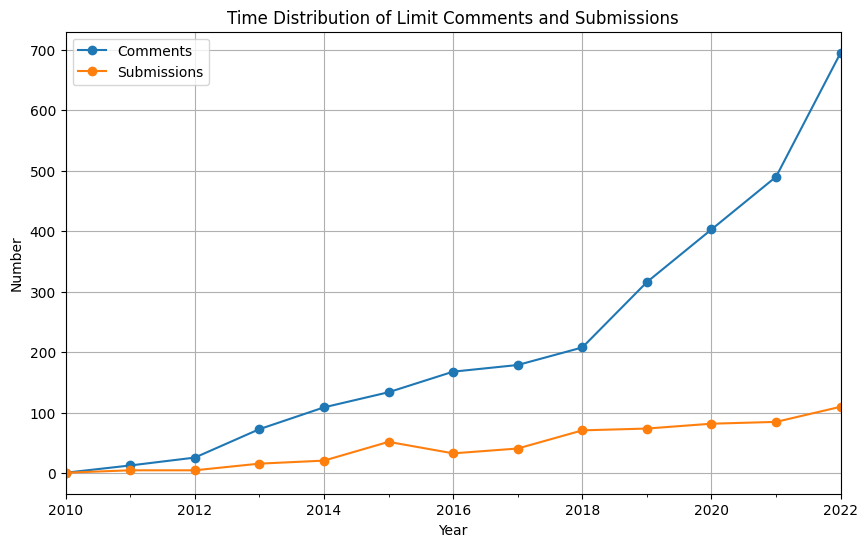

In [ ]:
import matplotlib.pyplot as plt

# Extract year from the datetime column in comments dataframe
merged_subset_2['year_month'] = merged_subset_2['created_utc'].dt.to_period('Y')

# Group by year and count the occurrences in comments dataframe
time_distribution_comments = merged_subset_2.groupby('year_month').size()

# Extract year from the datetime column in submissions dataframe
merged_subset_1['year_month'] = merged_subset_1['created_utc'].dt.to_period('Y')

# Group by year and count the occurrences in submissions dataframe
time_distribution_submissions = merged_subset_1.groupby('year_month').size()

# Plot the line chart for comments
time_distribution_comments.plot(kind='line', marker='o', figsize=(10, 6), label='Comments')

# Plot the line chart for submissions
time_distribution_submissions.plot(kind='line', marker='o', figsize=(10, 6), label='Submissions')

plt.title('Time Distribution of Limit Comments and Submissions')
plt.xlabel('Year')
plt.ylabel('Number')
plt.legend()
plt.grid(True)
plt.show()


# 3. Topic Modeling + keyBERT

We use sentence embedding + kmeans to cluster topics

## Extract paragraphs and sentences contain "palliative"

In [ ]:
import pandas as pd
file_path = 'data/final/'
submissions = pd.read_csv(file_path + 'subset1_submissions_limit.csv')
comments = pd.read_csv(file_path + 'subset2_comments_limit.csv')

clean submissions:

In [ ]:
import re
# clean selftext
submissions['selftext'] = submissions['selftext'].apply(lambda x: '' if x in ["[deleted]", "[removed]"] else x)

submissions['content'] = submissions['title'].fillna('') + '\n\n' + submissions['selftext'].fillna('')

# Ensure 'selftext' column contains only strings
submissions['content'] = submissions['content'].astype(str)

# Split paragraphs using any whitespace characters
submissions['paragraph'] = submissions['content'].apply(lambda x: re.split(r'\s+', x))

# Extract paragraphs with 'palliative', no matter lower case or upper case
submissions['paragraph_with_palliative'] = submissions['paragraph'].apply(lambda paragraphs: ' '.join(paragraphs) if any(re.search(r'palliative', p, flags=re.IGNORECASE) for p in paragraphs) else '')

# From 'paragraph_with_palliative', extract sentences containing 'palliative'
submissions['sentence_with_palliative'] = submissions['paragraph_with_palliative'].apply(lambda paragraph: re.findall(r'[^;.!?]*palliative[^.!?]*[.!?]?', paragraph, flags=re.IGNORECASE))

# If you want to merge the sentences into a single string, you can use join method
submissions['sentence_with_palliative'] = submissions['sentence_with_palliative'].apply(lambda sentences: ' '.join(sentences).strip())

# Remove
submissions['palliative_as_first_sentence'] = submissions['paragraph_with_palliative'].apply(lambda paragraph: re.findall(r'[^;.!?]*palliative.*', paragraph, flags=re.IGNORECASE))
submissions['palliative_as_first_sentence'] = submissions['palliative_as_first_sentence'].apply(lambda sentences: ' '.join(sentences).strip())

submissions = submissions.drop('paragraph', axis=1)

submissions.to_csv(file_path + 'subset1_submissions_paragraph_sentence.csv')

clean comments:

In [ ]:
# Ensure 'body' column contains only strings
comments['body'] = comments['body'].astype(str)

# Split paragraphs using any whitespace characters
comments['paragraph'] = comments['body'].apply(lambda x: re.split(r'\s+', x))

# Extract paragraphs with 'palliative', no matter lower case or upper case
comments['paragraph_with_palliative'] = comments['paragraph'].apply(lambda paragraphs: ' '.join(paragraphs) if any(re.search(r'palliative', p, flags=re.IGNORECASE) for p in paragraphs) else '')

# From 'paragraph_with_palliative', extract sentences containing 'palliative'
comments['sentence_with_palliative'] = comments['paragraph_with_palliative'].apply(lambda paragraph: re.findall(r'[^;.!?]*palliative[^.!?]*[.!?]?', paragraph, flags=re.IGNORECASE))

# If you want to merge the sentences into a single string, you can use join method
comments['sentence_with_palliative'] = comments['sentence_with_palliative'].apply(lambda sentences: ' '.join(sentences).strip())

# remove sentences before
comments['palliative_as_first_sentence'] = comments['paragraph_with_palliative'].apply(lambda paragraph: re.findall(r'[^;.!?]*palliative.*', paragraph, flags=re.IGNORECASE))
comments['palliative_as_first_sentence'] = comments['palliative_as_first_sentence'].apply(lambda sentences: ' '.join(sentences).strip())

# Remove
comments = comments.drop('paragraph', axis=1)

comments.to_csv(file_path + 'subset2_comments_paragraph_sentence.csv')

In [ ]:
file_path = 'data/final/'

df_submission = pd.read_csv(file_path + 'subset1_submissions_paragraph_sentence.csv')
df_comment = pd.read_csv(file_path + 'subset2_comments_paragraph_sentence.csv')

corpus_submission = df_submission['paragraph_with_palliative']

corpus_comment = df_comment['paragraph_with_palliative']

## Clustering:

In [ ]:
!pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
#  print cluster sizes
def print_cluster_sizes(model):
  cnt_perCluster = {}
  for c in model.labels_:
    cnt_perCluster[c] = cnt_perCluster.get(c, 0)+1
  print(cnt_perCluster)

In [ ]:
# print documents closest to each centroid
# sometimes we see a doc from another cluster j ends up in the list of the closest to centroid i
# this can happen when two clusters share some characteristics,
# e.g. cluster i is about hanging out with friend, cluster j is about entertainment, a doc about going to movie with friends may be close to both centroids

import numpy as np
def print_docs_closest_to_centroids(model, vec, n):
  K = len(model.cluster_centers_)
  for j in range(K):
    d = model.transform(vec)[:, j] # transform all docs to cluster-distance space
    idx = np.argsort(d)[:n] # find n docs closest to centroid

    c_idx = [m for m, label in enumerate(model.labels_) if label==j]  # find the index of all docs in cluster j
    print('\n\n======cluster #', j, ', cluster size:', len(c_idx))
    for i in idx:
      if i not in c_idx:
        print('[ this doc is in a different cluster #', model.labels_[i], '>>', corpus[i])
      else:
        print(corpus[i])
  return

## Cluster submissions:

In [ ]:
sbert_embeddings_submission = embedder.encode(corpus_submission)


In [ ]:
from sklearn.cluster import KMeans

K = 10  # change number of cluster if applicable
sbert_model_submission = KMeans(n_clusters=K, random_state=0)
sbert_model_submission.fit(sbert_embeddings_submission)
labels=sbert_model_submission.labels_.tolist()  # Save cluster labels in a separate list

corpus = corpus_submission
print_docs_closest_to_centroids(sbert_model_submission, sbert_embeddings_submission, 8)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(




======cluster # 0 , cluster size: 43
Emotional impact of a cancer diagnosis Hello, We are currently looking for people to take part in our research study on cancer survivorship and the emotional impact that cancer can have. Receiving a cancer diagnosis is a huge event in anyone’s life. Some people cope well emotionally, whilst others find it a distressing time. We believe that at such a difficult time, everyone deserves the best possible support. Our research study will compare those who are coping well with cancer, against those who are struggling. By studying the psychology of coping with cancer, we can create information and support systems to benefit everyone. To do this work, we need your help. Anyone over 16 years of age who has been diagnosed in the last 12 months can take part. However, if you've been told that the cancer is Stage 4, palliative or terminal, then I'm afraid you can't take part. If you decide to take part we will ask you to complete an online questionnaire now,

## Cluster comments:

In [ ]:
sbert_embeddings_comment = embedder.encode(corpus_comment)
from sklearn.cluster import KMeans

K = 7  # change number of cluster if applicable
sbert_model_comment = KMeans(n_clusters=K, random_state=0)
sbert_model_comment.fit(sbert_embeddings_comment)
labels=sbert_model_comment.labels_.tolist()  # Save cluster labels in a separate list
corpus = corpus_comment
print_docs_closest_to_centroids(sbert_model_comment, sbert_embeddings_comment, 8)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(




======cluster # 0 , cluster size: 372
I also am not at the point you are at yet... but for me I have chosen to do chemo while it is still looking to buy me some quality time down the road. My cancer is considered terminal but I have not been given a time frame yet, seeing how I respond to this front line chemo regimen. What I won't be doing is staying on chemo if it is not going to significantly alter my outcome. I've imagined myself in your shoes, and I would certainly be stopping chemo and squeezing every bit of life out of the time I had left. I do hope you tell those closest to you, I would be devastated if my loved one withheld that from me . Talk to your dr about palliative and hospice care... get as much as you possibly can out of those remaining months. I hope you find joy in the journey and at the very end, I wish you a peaceful death. It is what I wish for myself.
Prior to the chemo, I think my doctors expected 18 to 24 months of palliative care until I died from it. You ca

## keyBERT extract keywords
### Keywords of comments

In [ ]:
!pip install keybert

In [ ]:
corpus_submission1 = ' '.join(df_submission['paragraph_with_palliative'].astype(str))
len(corpus_submission1)

977097

In [ ]:
# Extract keywords from submission
from keybert import KeyBERT

model = KeyBERT()

# remove stopwords, extract top 20 keywords
keywords_submission = model.extract_keywords(corpus_submission1, stop_words='english', top_n=25)

print(keywords_submission)

[('depressed', 0.3963), ('depression', 0.3946), ('chemotherapy', 0.3709), ('oncology', 0.3465), ('cancerfamilysupport', 0.34), ('diagnosed', 0.3363), ('antidepressant', 0.3351), ('depressants', 0.319), ('cancercaregivers', 0.3149), ('chemo', 0.3139), ('depress', 0.3138), ('relapse', 0.3113), ('antidepressants', 0.3076), ('father_diagnosed_with_livercolon_cancer', 0.3007), ('coping', 0.2984), ('cancer', 0.296), ('myelofibrosis', 0.2904), ('miserable', 0.2895), ('lymphoma', 0.289), ('metastasis', 0.2857), ('oncologist', 0.2842), ('restlessness', 0.2841), ('myeloma', 0.2802), ('remission', 0.28), ('leukaemia', 0.28)]


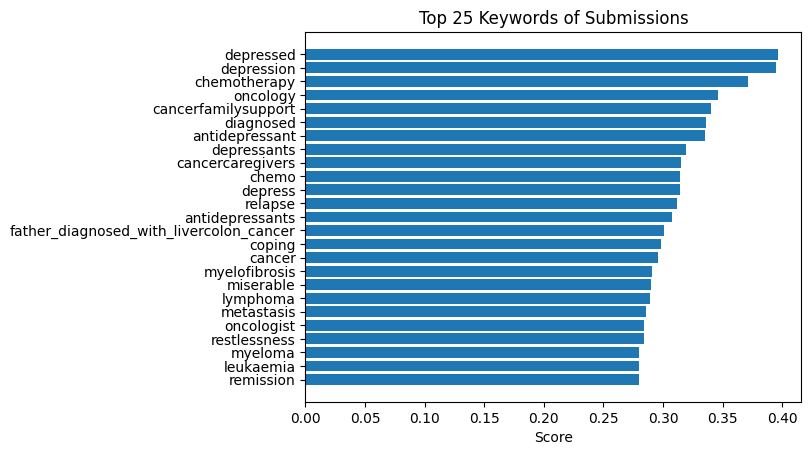

In [ ]:
import matplotlib.pyplot as plt

keywords_submission.sort(key=lambda x: x[1])
keywords, scores = zip(*keywords_submission)

plt.barh(keywords, scores)
plt.xlabel('Score')
plt.title('Top 25 Keywords of Submissions')
plt.show()

### Keywords of comments

In [ ]:
corpus_comment1 = ' '.join(df_comment['paragraph_with_palliative'].astype(str))
len(corpus_comment1)

keywords_comment = model.extract_keywords(corpus_comment1, stop_words='english', top_n=35)

print(keywords_comment)

[('malignancies', 0.465), ('malignancy', 0.4597), ('cancer', 0.4487), ('tumor', 0.4407), ('tumors', 0.4273), ('cancers', 0.4267), ('tumour', 0.4114), ('cancercare', 0.4075), ('chemotherapy', 0.4067), ('oncology', 0.4036), ('cancerscared', 0.3973), ('cancercaregivers', 0.391), ('cancerversary', 0.3894), ('tumorigenesis', 0.3773), ('carcinoma', 0.3766), ('breast_cancer', 0.3735), ('cholangiocarcinoma', 0.3703), ('cancerhelp', 0.3703), ('oncologynurseadvisor', 0.37), ('chemo', 0.3693), ('malignant', 0.368), ('tumours', 0.3634), ('metastasectomy', 0.3588), ('carcinomatosis', 0.3563), ('cholangiocarcinomas', 0.3542), ('choriocarcinoma', 0.3516), ('metastasis', 0.3504), ('cancertopics', 0.3481), ('carcinoid', 0.3458), ('cancerous', 0.3453), ('cancergrace', 0.3434), ('lymphoma', 0.3426), ('diagnosed', 0.341), ('adenocarcinoma', 0.3385), ('cancerouskelly', 0.3379)]


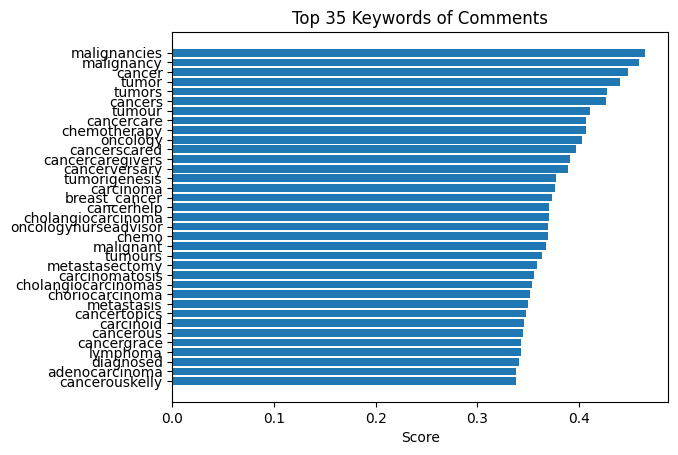

In [ ]:
keywords_comment.sort(key=lambda x: x[1])

keywords, scores = zip(*keywords_comment)

plt.barh(keywords, scores)
plt.xlabel('Score')
plt.title('Top 35 Keywords of Comments')
plt.show()

# 4. ChatGPT's stance classification analysis

In [ ]:
file_path = 'data/stance/'
stance = pd.read_csv(file_path+'palliative_stance.csv')
stance = stance[stance['label'] != 'not relevant']
stance.head(1)

,title+selftext,label,chatgpt-label_2,chatgpt-label_1,new_label,chatgpt-label_3
0,Psilocybin Therapy for End-of-Life Distress/Pa...,neutral,neutral,positive,neutral,neutral


In [ ]:
stance_3 = stance.copy()
stance_3['label'] = stance_3['label'].replace('cannot tell', 'neutral')
stance_3['chatgpt-label_2'] = stance_3['chatgpt-label_2'].replace('cannot tell', 'neutral')
stance_3['chatgpt-label_2'] = stance_3['chatgpt-label_2'].replace('cannot tell', 'neutral')

Prompt1:

What's the stance towards palliative care in the below submission/comment from Reddit? Answer positive, negative, neutral, or cannot tell as accurately as possible. The submission/comment is: ###{}###

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

y_test = stance_3['label'].values
y_pred_prompt1 = stance_3['chatgpt-label_2'].values

# Encode the labels using LabelEncoder
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_pred_encoded = label_encoder.transform(y_pred_prompt1)

# Confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred_encoded)
print("Confusion Matrix:")
print(cm)
print()

# Classification report
target_names = label_encoder.classes_
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_encoded, target_names=target_names))


Confusion Matrix:
[[ 0  1  0]
 [ 2 13 10]
 [ 1  7 15]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         1
     neutral       0.62      0.52      0.57        25
    positive       0.60      0.65      0.63        23

    accuracy                           0.57        49
   macro avg       0.41      0.39      0.40        49
weighted avg       0.60      0.57      0.58        49



Prompt2:

What's the stance towards palliative care in the below submission/comment from Reddit? Answer Support, Oppose, Neutral, or Unrelated as accurately as possible. The submission/comment is: ###{}###

In [ ]:
y_test_new = stance['new_label'].values
y_pred_new = stance['chatgpt-label_3'].values

# Encode the labels using LabelEncoder
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test_new)
y_pred_encoded = label_encoder.transform(y_pred_new)

# Confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred_encoded)
print("Confusion Matrix:")
print(cm)
print()

# Classification report
target_names = label_encoder.classes_
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_encoded, target_names=target_names))

Confusion Matrix:
[[10  1  8  1]
 [ 1  0  0  0]
 [ 9  0 14  0]
 [ 4  0  0  1]]

Classification Report:
              precision    recall  f1-score   support

     neutral       0.42      0.50      0.45        20
      oppose       0.00      0.00      0.00         1
     support       0.64      0.61      0.62        23
   unrelated       0.50      0.20      0.29         5

    accuracy                           0.51        49
   macro avg       0.39      0.33      0.34        49
weighted avg       0.52      0.51      0.51        49



# 5. Emotional support classification

Label = 0 : didn't look for/support emotional support

Label = 1 : Look for/support emotional support

In [2]:
import pandas as pd
file_path = 'data/emotional/'

df_emotion = pd.read_csv(file_path + 'subset1_submission_emotional.csv')
df_emotion = df_emotion[:121]
df_emotion['emotion'] = df_emotion['emotion'].astype(int)
print(len(df_emotion))

121


In [3]:
df_emotion.head(1)

,Unnamed: 0.1,Unnamed: 0,permalink,url,subreddit,subreddit_id,title,selftext,author,name,...,score,id,content,paragraph,paragraph_with_palliative,sentence_with_palliative,label,label_new,experience_knowledge,emotion
0,0,0,/r/testicularcancer/comments/34nla1/anyone_els...,http://www.reddit.com/r/testicularcancer/comme...,testicularcancer,t5_348dl,Anyone else struggle with depression post canc...,"Obvious throwaway here. In September of 2014, ...",[deleted],t3_34nla1,...,2,34nla1,Anyone else struggle with depression post canc...,"['Anyone', 'else', 'struggle', 'with', 'depres...",Anyone else struggle with depression post canc...,"This week, I went to see a doctor in the pain...",1,1,experience,1


In [4]:
from sklearn.model_selection import train_test_split

X = df_emotion['paragraph_with_palliative']
y = df_emotion['emotion']

# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Build SVM Model

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

boolean_vectorizer = CountVectorizer(encoding='latin-1', binary=True, stop_words='english')
# tfidf_vectorizer = TfidfVectorizer(encoding='latin-1', stop_words='english')

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
# Multinomial Naive Bayes
nb_clf = MultinomialNB()

# SVM
svm_clf = LinearSVC(C=1)

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

def cross_validation(vectorizer, X_train, y_train, clf, classifier):
    # Vectorize the training data
    clf_pipe = Pipeline([('vect', vectorizer),(clf, classifier)])
    scores = cross_val_score(clf_pipe, X_train, y_train, cv=3)
    print("Cross-validation scores: ", scores)
    print("Average cross-validation score: ", scores.mean())

In [8]:
# cross validation for sentiment task, using SVM
cross_validation(boolean_vectorizer, X_train, y_train, 'svm', svm_clf)

Cross-validation scores:  [0.71428571 0.82142857 0.82142857]
Average cross-validation score:  0.7857142857142856


In [9]:
# use the training data to train the model
X_train_vec = boolean_vectorizer.fit_transform(X_train)
X_test_vec = boolean_vectorizer.transform(X_test)
svm_clf.fit(X_train_vec,y_train)

from sklearn.metrics import confusion_matrix
y_pred = svm_clf.predict(X_test_vec)
cm=confusion_matrix(y_test, y_pred, labels=[0,1])
print(cm)
print()

from sklearn.metrics import classification_report
target_names = ['0','1']
print(classification_report(y_test, y_pred, target_names=target_names))


[[20  3]
 [ 9  5]]

              precision    recall  f1-score   support

           0       0.69      0.87      0.77        23
           1       0.62      0.36      0.45        14

    accuracy                           0.68        37
   macro avg       0.66      0.61      0.61        37
weighted avg       0.67      0.68      0.65        37



In [10]:
def display_top_features_svm(vectorizer, svm_clf):
    # Get the feature ranks for all categories
    feature_ranks = []
    for category_index in range(svm_clf.coef_.shape[0]):
        category_name = str(category_index)
        top_features = sorted(zip(svm_clf.coef_[category_index], vectorizer.get_feature_names_out()), reverse=True)[:20]
        print(f"Top 20 feature words for category {category_name}:")
        for rank, feature in enumerate(top_features, 1):
            print(f"{rank}. {feature[1]} ({feature[0]})")
        print()

display_top_features_svm(boolean_vectorizer, svm_clf)

Top 20 feature words for category 0:
1. dad (0.1426219734497015)
2. ll (0.12573048970997497)
3. wanted (0.11246861246771075)
4. sure (0.11174268732391876)
5. make (0.10936305857685671)
6. just (0.10912201508573732)
7. diagnosed (0.10026507749342645)
8. coming (0.09588765657774599)
9. normal (0.093294400465604)
10. deal (0.09232712129857135)
11. away (0.09036248429919663)
12. comfortable (0.08761056911837607)
13. father (0.08383187099022289)
14. lost (0.08184562274097827)
15. man (0.07662196956522732)
16. taken (0.0760401035993068)
17. pretty (0.06950458072469157)
18. forever (0.06824685556511507)
19. hard (0.06775749981675634)
20. friday (0.06697538348892149)



## Build Bert Model

In [11]:
!git clone -b master https://github.com/charles9n/bert-sklearn
!cd bert-sklearn; pip install .

Cloning into 'bert-sklearn'...
remote: Enumerating objects: 259, done.
remote: Total 259 (delta 0), reused 0 (delta 0), pack-reused 259
Receiving objects: 100% (259/259), 516.15 KiB | 3.71 MiB/s, done.
Resolving deltas: 100% (131/131), done.
Processing /content/bert-sklearn
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 1.9 MB/s eta 0:00:00
  Created wheel for bert-sklearn: filename=bert_sklearn-0.3.1-py3-none-any.whl size=54224 sha256=87069e0adc5b4dd2ed570739e0de37e7213ceda24070c7ad56cfbeb60367ac3f
  Stored in directory: /root/.cache/pip/wheels/29/f7/03/c9d257b287e1a5ef7ee4300cbbcd70cfbb13e8b6759da24477
Successfully built bert-sklearn


In [12]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from bert_sklearn import BertClassifier

# Specify the BERT model type
bert_model = 'bert-base-uncased'



In [13]:
model = BertClassifier(bert_model, epochs=2, label_list=[0, 1])
print(model)
model.fit(X_train, y_train)

Building sklearn text classifier...
BertClassifier(epochs=2, label_list=[0, 1])


100%|██████████| 231508/231508 [00:00<00:00, 2722606.63B/s]


Loading bert-base-uncased model...


100%|██████████| 433/433 [00:00<00:00, 112183.19B/s]


Defaulting to linear classifier/regressor
Loading Pytorch checkpoint

train data size: 76, validation data size: 8



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training  :   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/bert_sklearn/model/pytorch_pretrained/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1519.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Validating:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch 1, Train loss: 0.6461, Val loss: 0.5275, Val accy: 75.00%



Training  :   0%|          | 0/3 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch 2, Train loss: 0.5376, Val loss: 0.5323, Val accy: 75.00%



BertClassifier(do_lower_case=True, epochs=2, label_list=[0, 1])

In [14]:
from sklearn.metrics import f1_score
bert_acc = model.score(X_test, y_test)
print(bert_acc)

# test f1_score
y_pred_bert = model.predict(X_test)
bert_f1 = f1_score(y_test, y_pred_bert, average = None)
bert_f1_macro = f1_score(y_test, y_pred_bert, average = 'macro')

print(bert_f1)
print(bert_f1_macro)

Testing:   0%|          | 0/5 [00:00<?, ?it/s]


Loss: 0.6539, Accuracy: 62.16%
62.16216216216216


Predicting:   0%|          | 0/5 [00:00<?, ?it/s]

[0.76666667 0.        ]
0.38333333333333336


In [15]:
# Confusion matrice of BERT

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred_bert, labels=[0,1])
print(cm)
print()

from sklearn.metrics import classification_report
target_names = ['0','1']
print(classification_report(y_test, y_pred_bert, target_names=target_names))

[[23  0]
 [14  0]]

              precision    recall  f1-score   support

           0       0.62      1.00      0.77        23
           1       0.00      0.00      0.00        14

    accuracy                           0.62        37
   macro avg       0.31      0.50      0.38        37
weighted avg       0.39      0.62      0.48        37



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
